In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

pd.set_option('future.no_silent_downcasting', True)

# Import Data

two different versions of df, and make lists of columns

In [2]:
df_og = pd.read_csv('data/df_combo.csv', index_col=0) # no standardisation, but categories combined

cont_cols = []
cat_cols = [col for col in df_og.columns if df_og[col].dtype=='object']

for col in df_og.columns:
    if ((df_og[col].dtype=="object") or (len(df_og[col].unique())<5)):
        if (df_og[col].dtype!="object"):
            cat_cols.append(col)
    else:
        cont_cols.append(col)

un_log_cols = ['age', 'Total_income', 'Years_employed']

log_cols = cont_cols.copy()

for col in un_log_cols:
    log_cols.append(f'log_{col}')
    log_cols.remove(col)

In [3]:
df = pd.read_csv('data/df_stand2.csv', index_col=0) # preprocessed and standardised data
df.head()

,Exited,gender,age,term_deposit,Own_car,Own_property,credit_score,tenure,balance,Unemployed,...,Family_status_Widow,Housing_type_House/Apartment,Housing_type_Rented or Social Housing,Housing_type_With parents,Occupation_type_High-skill,Occupation_type_Low-skill,Occupation_type_Other,log_age,log_Total_income,log_Years_employed
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,0.291924,0,1,1,-0.324265,-1.040811,-1.222766,0,...,False,False,True,False,False,False,True,3.761200,12.965712,2.597906
5008806,0,1,0.196638,0,1,1,-0.437972,-1.386822,0.120305,0,...,False,True,False,False,False,True,False,3.737670,11.630717,1.412154
5008808,1,1,0.291924,0,0,1,-1.533701,1.035252,1.335893,0,...,False,True,False,False,False,True,False,3.761200,12.506181,2.235735
5008812,0,1,0.006065,0,0,1,0.502700,-1.386822,-1.222766,1,...,False,True,False,False,False,False,True,3.688879,12.554971,0.000000
5008815,0,1,0.387210,0,1,1,2.063597,-1.040811,0.788620,0,...,False,True,False,False,True,False,False,3.784190,12.506181,1.133159


# Check if Age Correlates with Target

In [4]:
if 'Target' not in log_cols:
    log_cols.append('Target')

p_values = []
c_values = {}
for col in log_cols:  # Replace with your continuous variable names
    corr, p_val = stats.pearsonr(df[col], df['Target'])
    p_values.append(p_val)
    c_values[col] = corr

p_values_df = pd.DataFrame.from_dict(c_values, orient='index', columns=['Pearson Correlation'])
p_values_df['p-value'] = p_values
p_values_df['Significant'] = p_values_df['p-value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
p_values_df.sort_values(by=['Pearson Correlation'], ascending=False)

,Pearson Correlation,p-value,Significant
Target,1.000000,0.000000e+00,Yes
Account_length,0.077492,2.071463e-14,Yes
Num_children,0.012923,2.029391e-01,No
log_Total_income,0.011535,2.557663e-01,No
credit_score,0.007591,4.545468e-01,No
log_age,0.006746,5.062636e-01,No
log_Years_employed,0.005733,5.721602e-01,No
tenure,-0.004452,6.609179e-01,No
balance,-0.004745,6.401669e-01,No


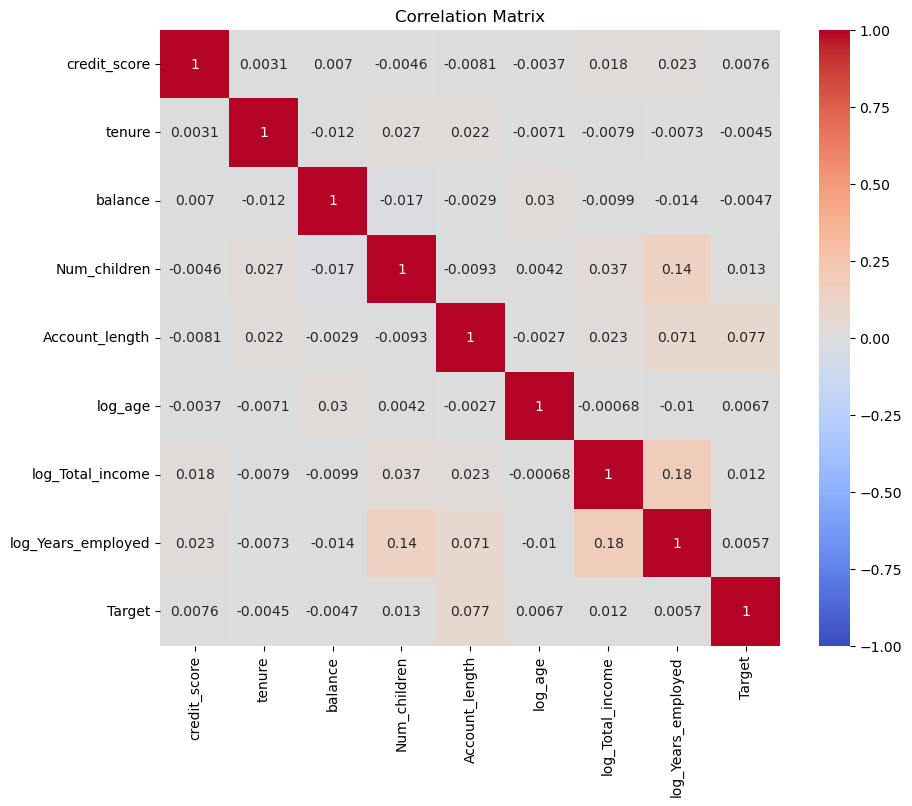

In [5]:
df_cont = df[log_cols]
corr_matrix = df_cont.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### Looking for other factors to compare with age

In [6]:
chi_square_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(df_og[col], df_og['Target'])
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
    chi_square_results[col] = {'chi2_stat': chi2_stat, 'p_value': p_val}

chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index')
chi_square_df['Significant'] = chi_square_df['p_value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
chi_square_df.rename(columns={'chi2_stat': 'Chi-Square Statistic', 'p_value': 'p-value'}, inplace=True)

chi_square_df.sort_values(by=['Chi-Square Statistic'], ascending=False)

,Chi-Square Statistic,p-value,Significant
Target,9700.282271,0.000000,Yes
Family_status,8.263560,0.082387,No
Own_property,7.559452,0.005970,Yes
Unemployed,5.840184,0.015664,Yes
Occupation_type,4.512977,0.104718,No
credit_card,2.591513,0.107438,No
Housing_type,2.438122,0.295508,No
Income_type,2.353742,0.502304,No
Education_type,2.298543,0.129495,No
Geography,2.296164,0.317245,No


# Random Forest for Feature Importance

In [7]:
X = df.drop(columns=un_log_cols)
X = X.drop(columns=['Target'])
y = df['Target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_importances = []

rankings = []
accuracies = []
precisions = []
f1s = []
recalls = []
false_ps = []

# Evaluate the model and get feature importances across cross-validation splits
for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    rf_model.fit(X_kf_train, y_kf_train)
    importances = rf_model.feature_importances_
    all_importances.append(importances)

    y_pred = rf_model.predict(X_kf_val)

    accuracies.append(accuracy_score(y_kf_val, y_pred))
    precisions.append(precision_score(y_kf_val, y_pred, zero_division=np.nan))
    f1s.append(f1_score(y_kf_val, y_pred, zero_division=np.nan))
    recalls.append(recall_score(y_kf_val, y_pred, zero_division=np.nan))
    conf = confusion_matrix(y_kf_val, y_pred)
    false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))


all_importances_df = pd.DataFrame(all_importances, columns=X.columns)

summary_importance_df = all_importances_df.T

summary_importance_df['Mean Importance'] = all_importances_df.mean()
summary_importance_df['Std Dev Importance'] = all_importances_df.std()

summary_importance_df = summary_importance_df.sort_values(by='Mean Importance', ascending=False)
feature_importances = summary_importance_df['Mean Importance']

summary_importance_df.head(10)

,0,1,2,3,4,Mean Importance,Std Dev Importance
Account_length,0.119373,0.117880,0.119773,0.119569,0.122877,0.119894,0.001827
credit_score,0.110714,0.111757,0.112753,0.113838,0.112290,0.112270,0.001159
log_Years_employed,0.100318,0.102840,0.099447,0.101529,0.098380,0.100503,0.001744
log_age,0.098308,0.098559,0.098486,0.096685,0.098246,0.098057,0.000777
log_Total_income,0.090551,0.091690,0.092526,0.092568,0.090336,0.091534,0.001058
balance,0.085293,0.086894,0.084336,0.084686,0.086685,0.085579,0.001159
tenure,0.073959,0.070975,0.071881,0.070866,0.071260,0.071788,0.001276
Num_children,0.027380,0.025774,0.026351,0.027016,0.024802,0.026264,0.001024
gender,0.020267,0.020237,0.019916,0.020192,0.020976,0.020318,0.000393
Own_car,0.018354,0.018919,0.019556,0.018160,0.019208,0.018839,0.000582


In [9]:
scores = np.array([accuracies, precisions, recalls, f1s, false_ps]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'False Positive Rate'])
df_scores.loc['Mean'] = df_scores.mean()
df_scores

,Accuracy,Precision,Recall,F1,False Positive Rate
0,0.882239,NaN,0.0,0.0,0.0
1,0.871300,NaN,0.0,0.0,0.0
2,0.867354,NaN,0.0,0.0,0.0
3,0.862202,NaN,0.0,0.0,0.0
4,0.873149,NaN,0.0,0.0,0.0
Mean,0.871249,NaN,0.0,0.0,0.0


# Recursive Feature Elimination (RFE)

In [10]:
# Initialize RFE with Random Forest
rfe = RFE(estimator=rf_model, n_features_to_select=5)

rankings = []
accuracies = []
precisions = []
f1s = []
recalls = []
false_ps = []

# Evaluate the model and get feature importances across cross-validation splits
for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    rfe.fit(X_kf_train, y_kf_train)
    rfe_rank = rfe.ranking_
    rankings.append(rfe_rank)

    y_pred = rfe.predict(X_kf_val)

    accuracies.append(accuracy_score(y_kf_val, y_pred))
    precisions.append(precision_score(y_kf_val, y_pred, zero_division=np.nan))
    f1s.append(f1_score(y_kf_val, y_pred, zero_division=np.nan))
    recalls.append(recall_score(y_kf_val, y_pred, zero_division=np.nan))
    conf = confusion_matrix(y_kf_val, y_pred)
    false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))


all_rankings_df = pd.DataFrame(rankings, columns=X.columns)

summary_importance_df = all_rankings_df.T

summary_importance_df['Mean Ranking'] = all_rankings_df.mean()
summary_importance_df['Std Dev Ranking'] = all_rankings_df.std()

summary_importance_df = summary_importance_df.sort_values(by='Mean Ranking')

rfe_ranking = summary_importance_df['Mean Ranking']
summary_importance_df.head(10)

,0,1,2,3,4,Mean Ranking,Std Dev Ranking
log_Years_employed,1,1,1,1,1,1.0,0.000000
log_age,1,1,1,1,1,1.0,0.000000
credit_score,1,1,1,1,1,1.0,0.000000
log_Total_income,1,1,1,1,1,1.0,0.000000
Account_length,1,1,1,1,1,1.0,0.000000
balance,2,2,2,2,2,2.0,0.000000
tenure,3,3,3,3,3,3.0,0.000000
Num_children,4,4,4,4,4,4.0,0.000000
gender,5,7,5,5,5,5.4,0.894427
Geography_Greece,6,5,6,6,6,5.8,0.447214


In [11]:
scores = np.array([accuracies, precisions, recalls, f1s, false_ps]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'False Positive Rate'])
df_scores.loc['Mean'] = df_scores.mean()
df_scores

,Accuracy,Precision,Recall,F1,False Positive Rate
0,0.882239,NaN,0.000000,0.000000,0.000000
1,0.870656,0.00,0.000000,0.000000,0.000739
2,0.867997,1.00,0.004854,0.009662,0.000000
3,0.860914,0.00,0.000000,0.000000,0.001494
4,0.870573,0.00,0.000000,0.000000,0.002950
Mean,0.870476,0.25,0.000971,0.001932,0.001036


In [12]:
# Initialize RFE with Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=300)
rfe = RFE(estimator=lr_model, n_features_to_select=5)

rankings = []
accuracies = []
precisions = []
f1s = []
recalls = []
false_ps = []

# Evaluate the model and get feature importances across cross-validation splits
for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    rfe.fit(X_kf_train, y_kf_train)
    rfe_rank = rfe.ranking_
    rankings.append(rfe_rank)

    y_pred = rfe.predict(X_kf_val)

    accuracies.append(accuracy_score(y_kf_val, y_pred))
    precisions.append(precision_score(y_kf_val, y_pred, zero_division=np.nan))
    f1s.append(f1_score(y_kf_val, y_pred, zero_division=np.nan))
    recalls.append(recall_score(y_kf_val, y_pred, zero_division=np.nan))
    conf = confusion_matrix(y_kf_val, y_pred)
    false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

all_rankings_df = pd.DataFrame(rankings, columns=X.columns)

summary_importance_df = all_rankings_df.T

summary_importance_df['Mean Ranking'] = all_rankings_df.mean()
summary_importance_df['Std Dev Ranking'] = all_rankings_df.std()

summary_importance_df = summary_importance_df.sort_values(by='Mean Ranking')

rfe_ranking_lr = summary_importance_df['Mean Ranking']
summary_importance_df.head(10)

,0,1,2,3,4,Mean Ranking,Std Dev Ranking
Income_type_Commercial associate,1,1,1,1,1,1.0,0.000000
Income_type_Working,1,1,1,1,1,1.0,0.000000
Unemployed,1,1,1,1,1,1.0,0.000000
Income_type_State servant,1,1,1,1,1,1.0,0.000000
Income_type_Pensioner or Student,1,1,1,1,1,1.0,0.000000
Account_length,3,2,3,3,2,2.6,0.547723
Family_status_Single / not married,4,4,5,7,3,4.6,1.516575
Own_property,5,5,2,6,5,4.6,1.516575
Family_status_Separated,2,11,13,2,10,7.6,5.224940
Occupation_type_Other,23,6,4,5,4,8.4,8.203658


In [13]:
scores = np.array([accuracies, precisions, recalls, f1s, false_ps]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'False Positive Rate'])
df_scores.loc['Mean'] = df_scores.mean()
df_scores

,Accuracy,Precision,Recall,F1,False Positive Rate
0,0.312741,0.120172,0.765027,0.207715,0.747629
1,0.626770,0.127451,0.325000,0.183099,0.328656
2,0.622666,0.133205,0.334951,0.190608,0.333333
3,0.323889,0.138408,0.747664,0.233577,0.743839
4,0.268513,0.127676,0.817259,0.220850,0.811209
Mean,0.430916,0.129382,0.597980,0.207170,0.592933


# Selecting Features to Compare with Age

credit_score because it scores highly in feature importance and the random forest RFE and because it makes sense from a domain knowledge point of view

log_Years_employed/Unemployed - these are correlated so only need to include one of them. They score highly in correlation analysis, feature importance and both RFEs

In [14]:
features = ['log_age', 'log_Years_employed', 'credit_score', 'Unemployed']

### Check none of the chosen features correlate and are redundant

I expect log_Years_employed and Unemployed to be

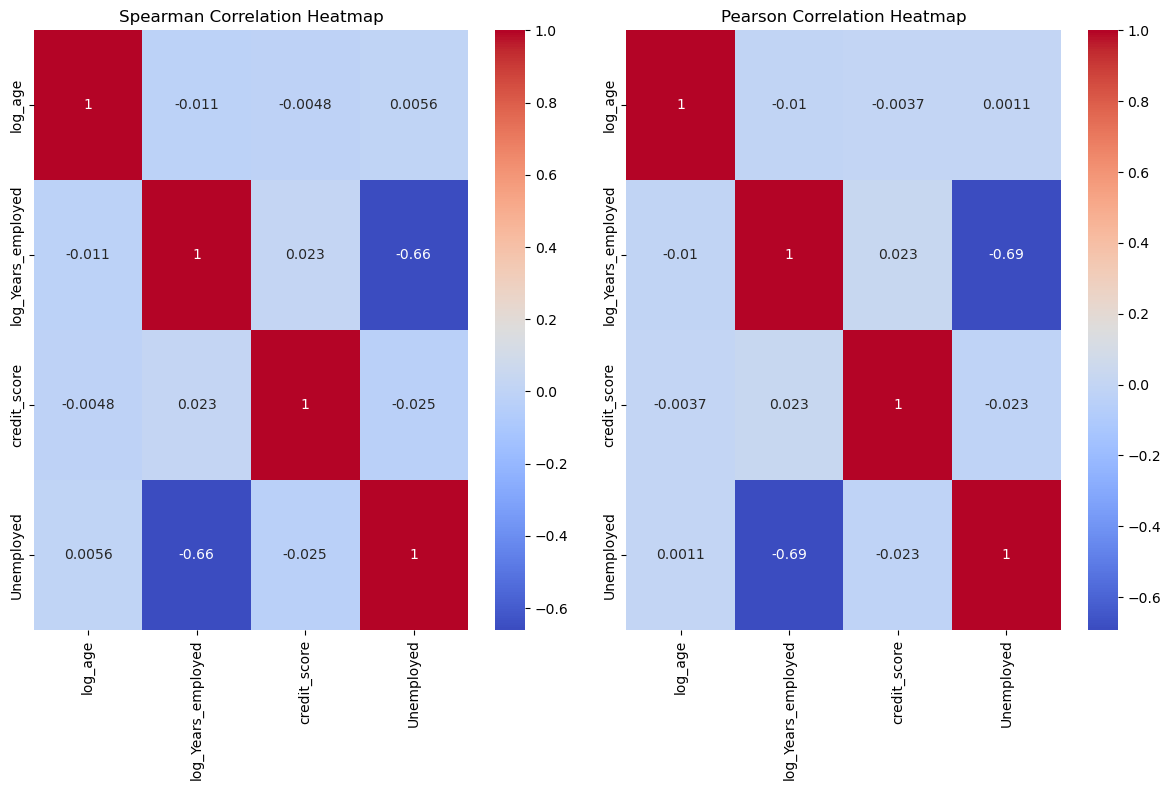

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

correlation_matrix = df[features].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Spearman Correlation Heatmap')

correlation_matrix_pearson = df[features].corr(method='pearson')
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Pearson Correlation Heatmap')

# Adjust layout
plt.tight_layout()
plt.savefig('corrs.jpg')
plt.show()

# Plot Distributions

In [16]:
features = ['log_age', 'log_Years_employed', 'credit_score']

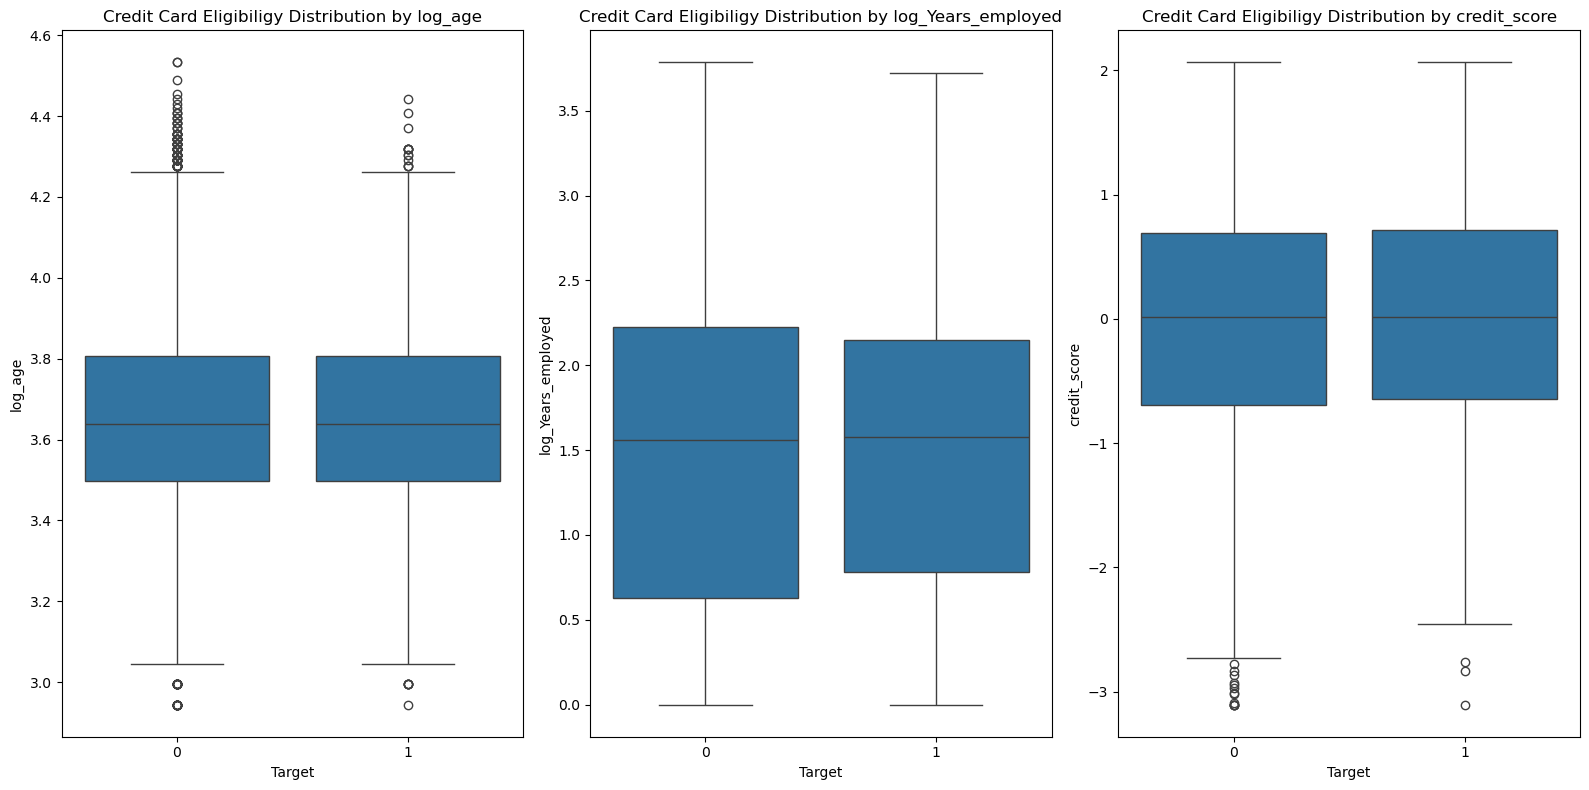

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(y=col, x='Target', data=df, ax=axes[i])
    axes[i].set_title(f'Credit Card Eligibiligy Distribution by {col}')

# Adjust layout
plt.tight_layout()
plt.savefig('target_distribution.jpg')
plt.show()

# Try them in Models

In [18]:
X = df[features]

### Logistic Regression

### Logistic Regressing with Class Weight Balancing

The target class is imbalanced so...

In [19]:
accuracies = []
precisions = []
recalls = []
f1s = []
confusions = []
false_ps = []

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression(class_weight='balanced') # because the target variable is not
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get coefficients
log_reg_coefficients = pd.DataFrame(model.coef_, columns=X.columns)
print(log_reg_coefficients)

              precision    recall  f1-score   support

           0       0.85      0.50      0.63      1659
           1       0.15      0.49      0.22       283

    accuracy                           0.50      1942
   macro avg       0.50      0.50      0.43      1942
weighted avg       0.75      0.50      0.57      1942

[[835 824]
 [143 140]]
    log_age  log_Years_employed  credit_score
0  0.066856            0.015951      0.050346


### Logistic Regression with SMOTE and Class Weight Balancing
trying SMOTE

In [20]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get coefficients
log_reg_smote_coefficients = pd.DataFrame(model.coef_, columns=X.columns)
print(log_reg_smote_coefficients)

              precision    recall  f1-score   support

           0       0.85      0.52      0.64      1659
           1       0.14      0.46      0.22       283

    accuracy                           0.51      1942
   macro avg       0.50      0.49      0.43      1942
weighted avg       0.75      0.51      0.58      1942

[[861 798]
 [152 131]]
    log_age  log_Years_employed  credit_score
0  0.103314            0.012474      0.030381


## Try Random Forest

### Random Forest with Class Weight Balancing

In [21]:
# Fit the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get feature importances
rf_importances = rf_model.feature_importances_
rf_importances = pd.DataFrame(rf_importances, index=X.columns, columns=["Importance"])
print(rf_importances)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1659
           1       0.16      0.02      0.03       283

    accuracy                           0.84      1942
   macro avg       0.51      0.50      0.47      1942
weighted avg       0.75      0.84      0.79      1942

[[1632   27]
 [ 278    5]]
                    Importance
log_age               0.226513
log_Years_employed    0.368783
credit_score          0.404704


### Random Forest with SMOTE and Class Weight Balancing

In [22]:
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get feature importances
rf_smote_importances = rf_model.feature_importances_
rf_smote_importances = pd.DataFrame(rf_importances, index=X.columns, columns=["Importance"])
print(rf_smote_importances)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1659
           1       0.14      0.14      0.14       283

    accuracy                           0.75      1942
   macro avg       0.50      0.50      0.50      1942
weighted avg       0.75      0.75      0.75      1942

[[1425  234]
 [ 244   39]]
                    Importance
log_age               0.226513
log_Years_employed    0.368783
credit_score          0.404704


# Visualisation

In [23]:
models = ['Logistic Regression', 'SMOTE + Logistic Regression',
          'Random Forest', 'SMOTE + Random Forest']

In [24]:
scores = np.array([accuracies, precisions, recalls, f1s, false_ps]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'False Positive Rate'], index=models)
df_scores

,Accuracy,Precision,Recall,F1,False Positive Rate
Logistic Regression,0.502060,0.145228,0.494700,0.224539,0.496685
SMOTE + Logistic Regression,0.510814,0.141012,0.462898,0.216172,0.481013
Random Forest,0.842945,0.156250,0.017668,0.031746,0.016275
SMOTE + Random Forest,0.753862,0.142857,0.137809,0.140288,0.141049


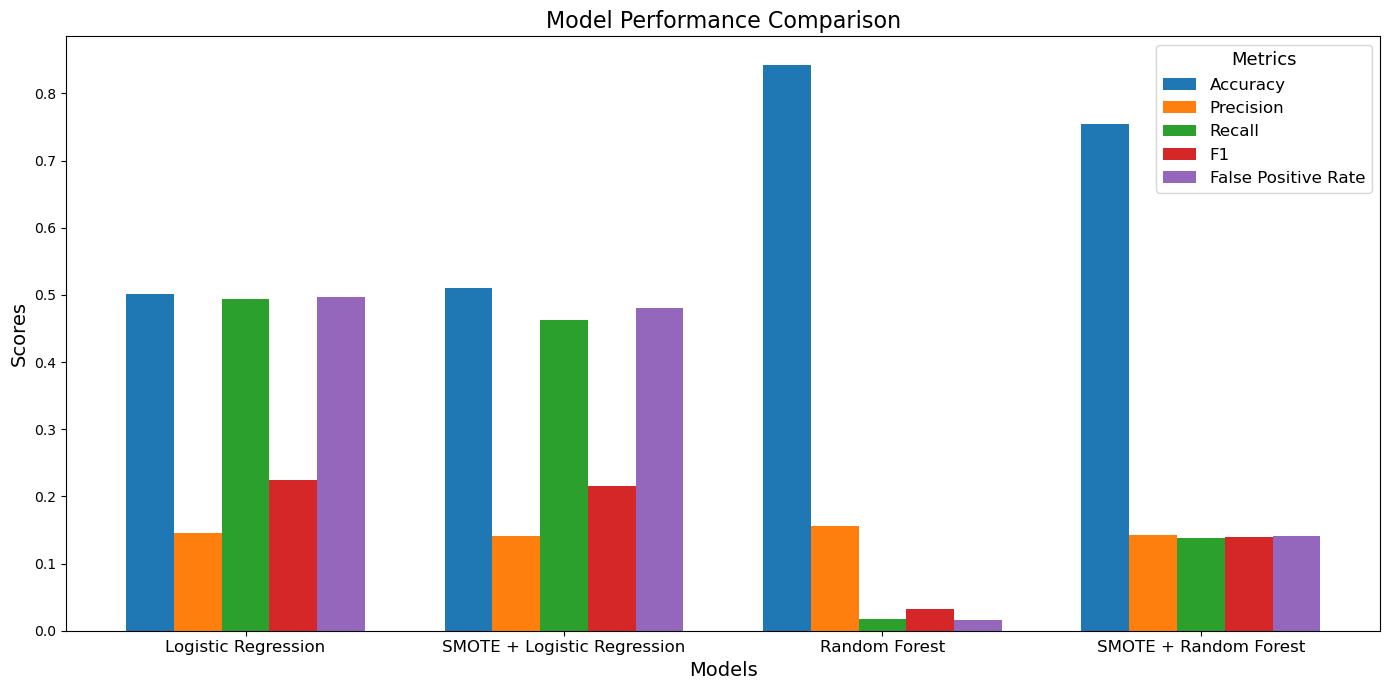

In [25]:
bar_width = 0.15  # Width of each bar
model_indices = np.arange(len(df_scores.index))  # Indices for each model

# Set figure size
plt.figure(figsize=(14, 7))

# Create bars for each metric
for i, column in enumerate(df_scores.columns):
    plt.bar(model_indices + (i - 2) * bar_width, df_scores[column], width=bar_width, label=column)

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)

# Add x-ticks for model names
plt.xticks(model_indices, df_scores.index, fontsize=12)

# Create legend
plt.legend(title='Metrics', fontsize=12, title_fontsize='13')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

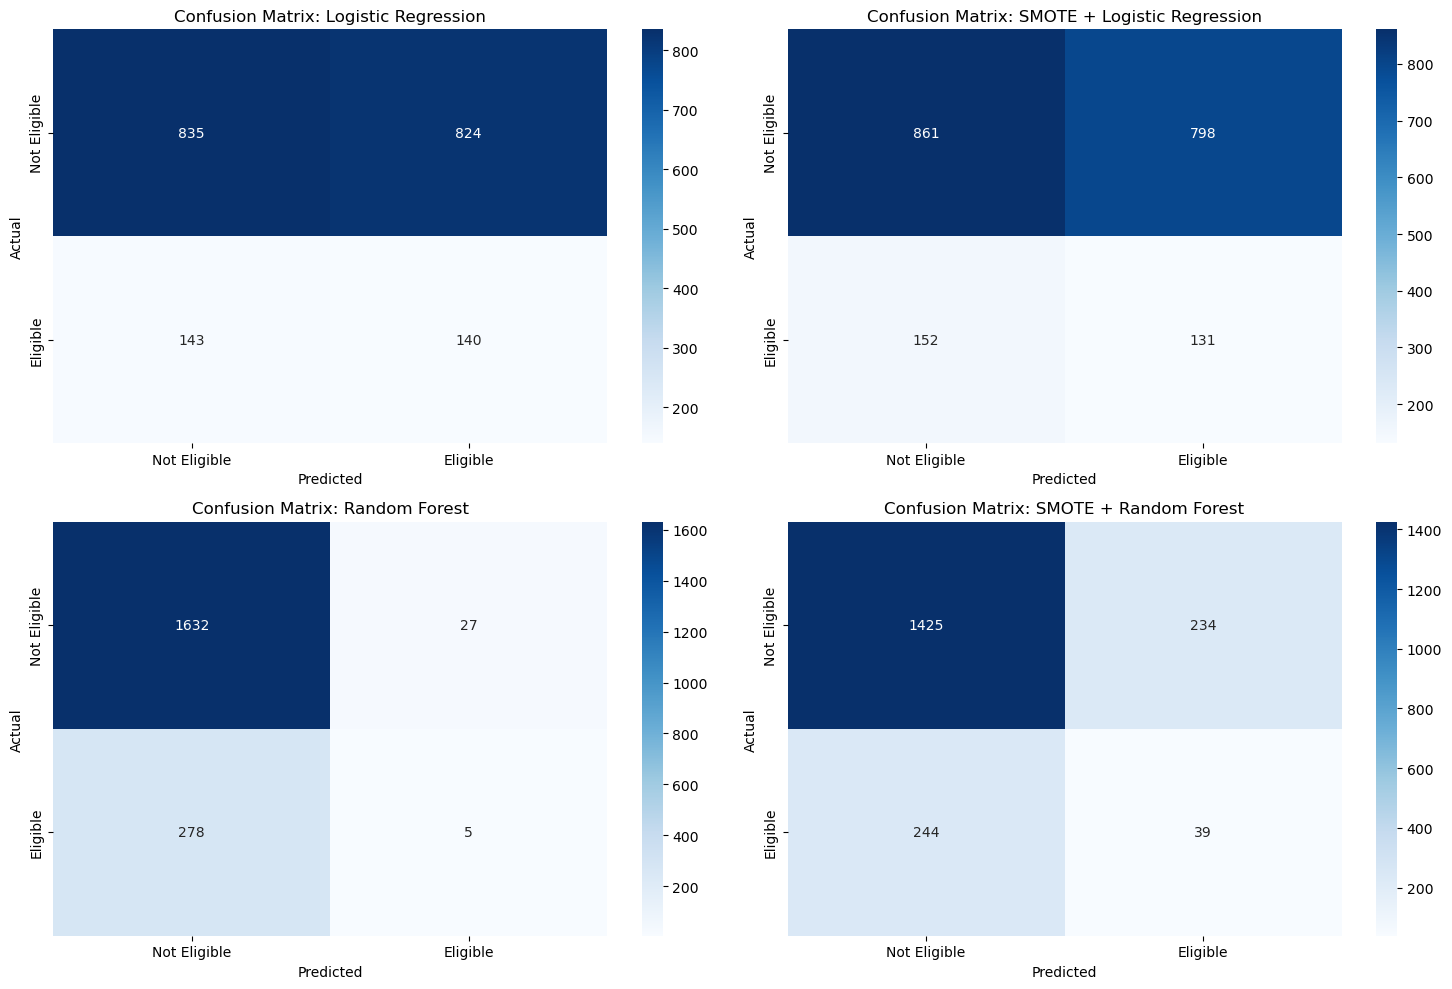

In [26]:
plt.figure(figsize=(15, 10))
for i, (model_name, cm) in enumerate(zip(models, confusions)):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Eligible', 'Eligible'],
                yticklabels=['Not Eligible', 'Eligible'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [27]:
combined_importances = pd.DataFrame({
    'Feature': ['log_age', 'log_Years_employed', 'credit_score'],
    'Logistic Regression': [log_reg_coefficients.iloc[0, 0], log_reg_coefficients.iloc[0, 1], log_reg_coefficients.iloc[0, 2]],
    'SMOTE + Logistic Regression': [log_reg_smote_coefficients.iloc[0, 0], log_reg_smote_coefficients.iloc[0, 1], log_reg_smote_coefficients.iloc[0, 2]],
    'Random Forest': [rf_importances.iloc[0, 0], rf_importances.iloc[1, 0], rf_importances.iloc[2, 0]],
    'SMOTE + Random Forest': [rf_smote_importances.iloc[0, 0], rf_smote_importances.iloc[1, 0], rf_smote_importances.iloc[2, 0]]
})
combined_importances.set_index('Feature', inplace=True)
combined_importances

,Logistic Regression,SMOTE + Logistic Regression,Random Forest,SMOTE + Random Forest
Feature,,,,
log_age,0.066856,0.103314,0.226513,0.226513
log_Years_employed,0.015951,0.012474,0.368783,0.368783
credit_score,0.050346,0.030381,0.404704,0.404704


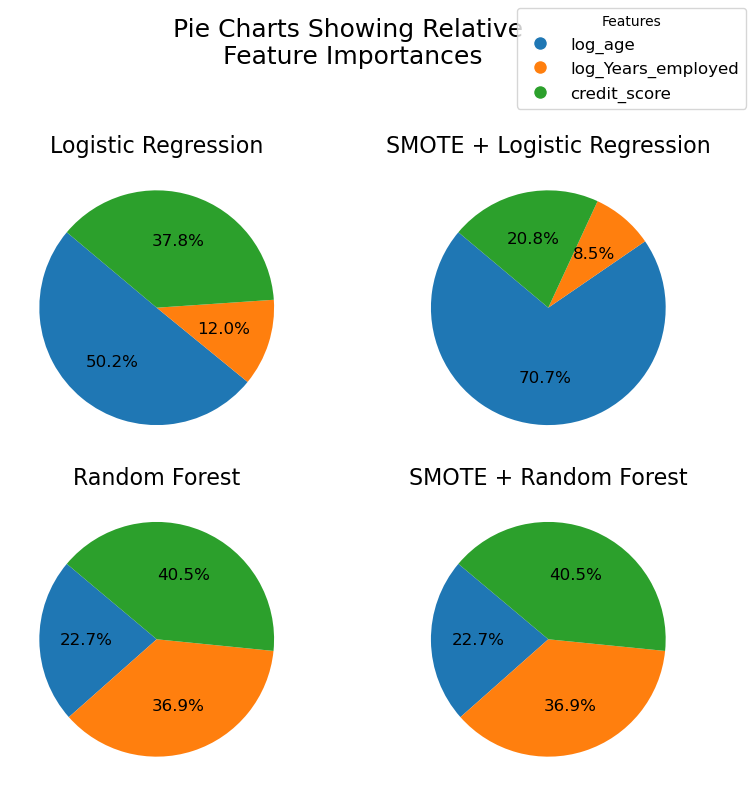

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Flatten axes array
axes = axes.flatten()

# Create pie charts
for i, col in enumerate(combined_importances.columns):
    wedges, texts, autotexts = axes[i].pie(
        combined_importances[col], 
        startangle=140, 
        autopct='%1.1f%%'
    )

    for text in autotexts:
        text.set_fontsize(12)
    
    # Set title and text size
    axes[i].set_title(f'{col}', fontsize=16)

# Create a single legend for the entire figure
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markersize=10, markerfacecolor=color) 
           for label, color in zip(combined_importances.index, ['#1f77b4', '#ff7f0e', '#2ca02c'])]

# Add the legend to the figure
fig.legend(handles=handles, title="Features", loc="upper right", fontsize=12)
fig.suptitle('Pie Charts Showing Relative \nFeature Importances', fontsize=18, ha='center')


plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig('feature_importance.jpg')
plt.show()

## Some useful tables for write up

In [29]:
p_values = []
c_values = {}
for col in features:  # Replace with your continuous variable names
    corr, p_val = stats.pearsonr(df[col], df['Target'])
    p_values.append(p_val)
    c_values[col] = corr

p_values_df = pd.DataFrame.from_dict(c_values, orient='index', columns=['Pearson Correlation'])
p_values_df['p-value'] = p_values
p_values_df['Significant'] = p_values_df['p-value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
p_values_df.sort_values(by=['Pearson Correlation'], ascending=False)

,Pearson Correlation,p-value,Significant
credit_score,0.007591,0.454547,No
log_age,0.006746,0.506264,No
log_Years_employed,0.005733,0.572160,No


In [30]:
data = {
    'Feature Importances': feature_importances.index[:5],
    'RFE Ranking (Random Forest)': rfe_ranking.index[:5],
    'RFE Ranking (Logistic Regression)': rfe_ranking_lr.index[:5]
}

df_rankings = pd.DataFrame(data)

df_rankings

,Feature Importances,RFE Ranking (Random Forest),RFE Ranking (Logistic Regression)
0,Account_length,log_Years_employed,Income_type_Commercial associate
1,credit_score,log_age,Income_type_Working
2,log_Years_employed,credit_score,Unemployed
3,log_age,log_Total_income,Income_type_State servant
4,log_Total_income,Account_length,Income_type_Pensioner or Student
